In [2]:
# fold6_dice_multi_weights-02-0.38.hdf5


import os

os.chdir("/scratch/yl4217/MS-Lesion-Segmentation/")

config = {}
config["weights_file"] = os.getcwd() + '/model/weight'
config["modality"] = ["FLAIR_preprocessed", "T1_preprocessed", "T2_preprocessed"]

config["patch_size"] = (64, 64, 64)  # switch to None to train on the whole image
config["patch_gap"] = 16
config["batch_size"] = 2
config["kfold"] = 5

config["input_shape"] = (len(config["modality"]), None, None, None)
config["depth"] = 4 # depth of layers for V/Unet
config["n_base_filters"] = 32
config["pool_size"] = (2, 2, 2)  # pool size for the max pooling operations
config["deconvolution"] = True  # if False, will use upsampling instead of deconvolution

config["patience"] = 10  # learning rate will be reduced after this many epochs if the validation loss is not improving
config["early_stop"] = 10  # training will be stopped after this many epochs without the validation loss improving
config["initial_learning_rate"] = 0.0000001
# config["initial_learning_rate"] = 0.00001
config["learning_rate_drop"] = 0.5  # factor by which the learning rate will be reduced
config["n_epochs"] = 10


from model.multi_data import *
from model.multi_generator import *
from model.modelDice import *
from model.recon import *

weight_path = ['/model/weight/fold6_dice_multi_weights-02-0.38.hdf5',
              ]
weight_name = ['dice',
              ]


d = Data(config["modality"])
d.load_data(config["patch_size"])
train_num, valid_num = d.prekfold(config["patch_size"], config["patch_gap"], config["batch_size"], config["kfold"])

# train_generator = DataGenerator(d.moda, d.input, d.target, d.patch_index, d.kfold, d.batch_size,
#                                 d.patch_size, d.patch_gap, d.valid_index, True)
# valid_generator = DataGenerator(d.moda, d.input, d.target, d.patch_index, d.kfold, d.batch_size,
#                                 d.patch_size, d.patch_gap, d.valid_index, True)



Using TensorFlow backend.


In [9]:
next(iter(d.input.values()))['(128, 256, 256)'].shape[1:]

(128, 256, 256)

In [14]:

for i_weight in range(len(weight_path)):
    print("loading weight: ", weight_name[i_weight])
    model = unet_model_3d(input_shape=config["input_shape"],
                                  pool_size=config["pool_size"],
                                  initial_learning_rate=config["initial_learning_rate"],
                                  deconvolution=config["deconvolution"],
                                  depth=config["depth"],
                                  n_base_filters=config["n_base_filters"])
    model.load_weights(os.getcwd() + weight_path[i_weight]) 
    
    print(d.valid_index)
    fold_index = 0
    for i in d.valid_index:
        # i: shape
        j = d.valid_index[i][fold_index]
        sample_input = next(iter(d.input.values()))
        output = Reconstruct(j, sample_input[i].shape[1:], config["patch_size"], False)
        image = Reconstruct(j, sample_input[i].shape[1:], config["patch_size"], False)
        target = Reconstruct(j, sample_input[i].shape[1:], config["patch_size"], False)
        for ind in range(d.patch_index[i][j].shape[0]):
            
            patch = d.patch_index[i][j][ind]
            img = []
            for m in d.moda:
                data_image = d.input[m][i][j]
                img.append(data_image[patch[0]:patch[0]+d.patch_size[0], 
                                 patch[1]:patch[1]+d.patch_size[1], 
                                 patch[2]:patch[2]+d.patch_size[2]])
            
            data_image = d.input["FLAIR_preprocessed"][i][j]
            image_i = np.expand_dims(data_image[patch[0]:patch[0]+d.patch_size[0], 
                                     patch[1]:patch[1]+d.patch_size[1], 
                                     patch[2]:patch[2]+d.patch_size[2]], axis=0)
            
            data_target = d.target[i][j]
            target_i = data_target[patch[0]:patch[0]+d.patch_size[0], 
                             patch[1]:patch[1]+d.patch_size[1], 
                             patch[2]:patch[2]+d.patch_size[2]]
            result = model.predict(np.array(np.expand_dims(img, axis=0)))
            output.add(result, patch)
            image.add(image_i, patch)
            target.add(target_i, patch)
            
        dir_name = './model/h5df_data/recon/' + weight_name[i_weight] + '/'
        os.makedirs(os.path.dirname(dir_name), exist_ok=True)
        file_name = '/recon/' + weight_name[i_weight] + '/'+ str(d.data[i][j][0].shape)
        output.store(file_name + "_muti_uniform_output")
        image.store(file_name + "_multi_input_flair")
        target.store(file_name + "_multi_target")

print("finish reconstructing image")


loading weight:  dice
{'(128, 256, 256)': [1, 2, 0, 4, 3], '(192, 512, 512)': [1, 3, 4, 0, 2], '(320, 384, 384)': [4, 1, 2, 0, 3]}


KeyboardInterrupt: 

target {'[192 512 512]': <HDF5 file "(192, 512, 512)_target.h5" (mode r)>, '[320 384 384]': <HDF5 file "(320, 384, 384)_target.h5" (mode r)>, '[128 256 256]': <HDF5 file "(128, 256, 256)_target.h5" (mode r)>}
uniform {'[128 256 256]': <HDF5 file "(128, 256, 256)_uniform_output.h5" (mode r)>, '[192 512 512]': <HDF5 file "(192, 512, 512)_uniform_output.h5" (mode r)>, '[320 384 384]': <HDF5 file "(320, 384, 384)_uniform_output.h5" (mode r)>}
weight {}
finish determining the optimal threshold
finish restoring thresholded image


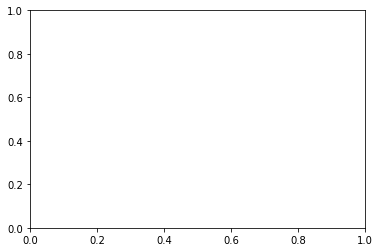

In [29]:
def fetch_file():
    path = os.getcwd() + '/model/h5df_data/recon/'
    root, sub_dir, _ = next(os.walk(path))
    total = {}
    for sub in sub_dir:
        _, _, sub_files = next(os.walk(root + sub))
        uniform = {}
        weight = {}
        target = {}
        for file in sub_files:
            if "nii" not in file and "threshold" not in file:
                cur_file = h5py.File(root + sub + '/' + file, 'r')
                if "weight" in file:
                    weight[str(cur_file["shape"][()])]= cur_file
                if "uniform" in file:
                    uniform[str(cur_file["shape"][()])]= cur_file
                if "target" in file:
                    target[str(cur_file["shape"][()])]= cur_file
        total[sub] = [target, uniform, weight]
    return total["dice"]

def fetch_threshold_file():
    path = os.getcwd() + '/model/h5df_data/recon/dice/'
    root, sub_dir, _ = next(os.walk(path))
    total = []
    for sub in sub_dir:
        _, _, sub_files = next(os.walk(root + sub))
        for file in sub_files:
            if "nii.gz" in file and "threshold" in file:
                total.append(path + sub + '/' + file)
    return total

def dice(y_true, y_pred, smooth=1.):
    y_true_f = np.array(y_true).flatten()
    y_pred_f = np.array(y_pred).flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    # tensorflow computation graph: will not configure print as one of the graph, unless using tf.Print()
    return (2.*intersection+smooth) / (np.sum(y_true_f)+np.sum(y_pred_f)+smooth)

def calc_thres(output, target):
    it = np.arange(0, 1.01, 0.01)
    dice_thre = []
    for i in it:
        dice_thre.append(dice(target, output>i))
    return dice_thre


total = fetch_file()
table = {0: "target", 1: "uniform", 2: "weight"}

for i in range(len(total)):
    print(table[i], total[i])
#     for j in range(len(total[i])):
#         print(table[j])
#         for k in total[i][j]:
#             print(total[i][j][k])

path = os.getcwd() + '/model/h5df_data/recon/'

j = 1
threshold = np.zeros(101)
for i in total[0]:
    threshold += calc_thres(total[1][i]["data"][:], total[0][i]["data"][:])
threshold /= len(total[0])
plt.plot(np.arange(0, 1.01, 0.01), threshold)
opt_dice = threshold[np.argmax(threshold)]
opt_thre = np.arange(0, 1.01, 0.01)[np.argmax(threshold)]
plt.savefig(path + 'dice/' + table[j] + '_dice_' + str(opt_dice) + '_opt_' + str(opt_thre) + '_threshold.png')
plt.clf()
plt.cla()
for i in total[0]:
    nib.save(nib.Nifti1Image(np.array(total[1][i]["data"][:]>opt_thre).astype(int), np.eye(4)), path + 'dice/' + os.path.basename(total[1][i].filename) + "_" + table[j] + "_" + str(opt_thre) + "_threshold.nii.gz")
        
print("finish determining the optimal threshold")

threshold_total = fetch_threshold_file()
for i in threshold_total:
    image = nib.load(i)
    nib.save(nib.Nifti1Image(image.get_fdata(), np.eye(4)), i)

print("finish restoring thresholded image")